In [1]:
%run nlp_utils.py

In [2]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [3]:
import tensorflow as tf
from tensorflow import keras

from nlp_utils import utils_plot_keras_training, add_preprocessed_text
from nlp_utils import create_stopwords, add_text_length, plot_distributions

from sklearn.model_selection import train_test_split
import nltk
import pandas as pd

import keras_tuner
from keras_tuner import HyperModel

import keras_nlp

import numpy as np
import math
import random

import os
import pickle

from IPython.display import display, HTML

from collections import Counter
from tqdm.notebook import trange, tqdm
from multiprocessing import Pool

from itertools import repeat
from functools import partial

2023-08-04 11:33:44.169732: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-04 11:33:44.444396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [4]:
train = pd.read_csv('data/train.csv', index_col=0)
validate = pd.read_csv('data/validate.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)

In [5]:
# train = pd.read_csv('train.csv', index_col=0)
# validate = pd.read_csv('validate.csv', index_col=0)
# test = pd.read_csv('test.csv', index_col=0)

In [6]:
tokenizer_train_corpus = pd.concat([train, validate], axis=0, ignore_index=True)

In [7]:
# train, validate2 = train_test_split(train, test_size=0.1, random_state=42)
# validate = pd.concat([validate, validate2], axis=0, ignore_index=True)

In [8]:
# validate.info()

In [9]:
tokenizer_train_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18870 entries, 0 to 18869
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   article           18870 non-null  object
 1   article_clean     18870 non-null  object
 2   highlights        18870 non-null  object
 3   highlights_clean  18870 non-null  object
dtypes: object(4)
memory usage: 589.8+ KB


In [10]:
train_article = train['article_clean'].tolist()
train_highlights = train['highlights_clean'].tolist()

validate_article = validate['article_clean'].tolist()
validate_highlights = validate['highlights_clean'].tolist()

tokenizer_train_article = tokenizer_train_corpus['article_clean'].tolist()
tokenizer_train_highlights = tokenizer_train_corpus['highlights_clean'].tolist()

In [11]:
def train_sentence_piece(text_samples, vocab_size, model_type, data_type):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)

    vocab = keras_nlp.tokenizers.compute_sentence_piece_proto(
        word_piece_ds,
        vocabulary_size=vocab_size,
        model_type=model_type,
        proto_output_file= 'sentencepiece/'+'sentencepiece'  + '_' + data_type + '_' +  'pubmed'  + '.spm',
        lowercase=False
    )

In [12]:
ART_VOCAB_SIZE = 15_000
HIGH_VOCAB_SIZE = 15_000


MODEL_UNIGRAM = 'unigram'
MODEL_WORD = 'word'

In [13]:
ART_VOCAB_SIZE = 9_207
HIGH_VOCAB_SIZE = 5_113

In [14]:
# proto_train_article = train_sentence_piece(
#     tokenizer_train_article,
#     vocab_size=ART_VOCAB_SIZE,
#     model_type=MODEL_UNIGRAM,
#     data_type='train_article'
# )

# proto_train_highlights = train_sentence_piece(
#     tokenizer_train_highlights,
#     vocab_size=HIGH_VOCAB_SIZE,
#     model_type=MODEL_UNIGRAM,
#     data_type='train_highlights'
# )

In [15]:
# proto_validate_article = train_sentence_piece(
#     validate_article,
#     vocab_size=ENG_VOCAB_SIZE,
#     model_type=MODEL_UNIGRAM,
#     data_type=' validate_article'
# )

# proto_validate_highlights = train_sentence_piece(
#     validate_highlights,
#     vocab_size=ENG_VOCAB_SIZE,
#     model_type=MODEL_UNIGRAM,
#     data_type='validate_highlights'
# )

In [16]:
train_article_for_tokenizer = tf.data.Dataset.from_tensor_slices([tokenizer_train_article])
train_highlights_for_tokenizer = tf.data.Dataset.from_tensor_slices([tokenizer_train_highlights])

article_tokenizer = keras_nlp.tokenizers.SentencePieceTokenizer(proto='sentencepiece/sentencepiece_train_article_pubmed.spm')
highlights_tokenizer = keras_nlp.tokenizers.SentencePieceTokenizer(proto='sentencepiece/sentencepiece_train_highlights_pubmed.spm')

train_article_sentencepiece = train_article_for_tokenizer.map(article_tokenizer)
train_highlights_sentencepiece = train_highlights_for_tokenizer.map(highlights_tokenizer)

2023-06-14 08:56:26.215625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:56:26.241283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:56:26.241782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:56:26.244393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:56:26.245109: I tensorflow/compile

In [17]:
article_tokenizer.vocabulary_size()

9207

In [18]:
highlights_tokenizer.vocabulary_size()

5113

In [19]:
highlights_tokenizer.token_to_id('_')

1

In [20]:
train_highlights_sentencepiece

<_MapDataset element_spec=RaggedTensorSpec(TensorShape([18870, None]), tf.int32, 1, tf.int64)>

In [21]:
from string import ascii_lowercase

r = []
for c in ascii_lowercase:
    tok = article_tokenizer.token_to_id(c)
    r.append(tok)
print(len(r))

26


In [22]:
len(ascii_lowercase)

26

In [23]:
train_article_sentencepiece

<_MapDataset element_spec=RaggedTensorSpec(TensorShape([18870, None]), tf.int32, 1, tf.int64)>

In [24]:
for i in range(20):
    print(article_tokenizer.id_to_token(i))

<pad>
<unk>
<s>
</s>
▁group
▁patient
▁
ed
▁difference
▁significantly
▁significant
▁month
▁mean
▁treatment
▁placebo
▁compared
▁respectively
▁score
▁control
▁rate


In [25]:
list(train_article_sentencepiece)[0][0]

2023-06-14 08:56:29.476514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1,18870]
	 [[{{node Placeholder/_0}}]]


<tf.Tensor: shape=(71,), dtype=int32, numpy=
array([  37,    5,  120,   22,  470,  365,   61,  363,  778,   38,    5,
        129,   54,   79,  123,  172, 1484,  567,   71,   22,   15,    5,
        129,   44, 2949,  641,   92,  567,  567,   71,  178,  125,  123,
        172,  106,  166,  669,   71,  383,  116,  123,  172,   19,   50,
         13,    4,   68,  850,   38,   54,  128,  345,  778,   38, 1920,
        105,   10,   55,    6,  799,   45,  378,    6,  765,  415,   92,
          5,  129,   15,    5,  129], dtype=int32)>

In [26]:
def train_word_piece(text_samples, vocab_size, reserved_tokens, data_type, article_type):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
        vocabulary_output_file="wordpiece/" + "wordpiece" + '_' + data_type + '_' + article_type + '_' + 'pubmed' + '.spm'

    )
    return vocab

In [27]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

# train_word_piece(tokenizer_train_highlights, HIGH_VOCAB_SIZE, reserved_tokens=reserved_tokens, data_type='train', article_type='highlights')

In [28]:
with open('wordpiece/wordpiece_train_highlights_pubmed', 'r', encoding='utf-8') as file:
    word_piece_vocab_highlights = [line.strip() for line in file.readlines()]

In [29]:
word_piece_vocab_highlights[:20]

['[PAD]',
 '[UNK]',
 '[START]',
 '[END]',
 'I',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o']

In [30]:
# train_word_piece(tokenizer_train_article, ART_VOCAB_SIZE, reserved_tokens=reserved_tokens, data_type='train', article_type='article')

In [31]:
with open('wordpiece/wordpiece_train_article_pubmed', 'r', encoding='utf-8') as file:
    word_piece_vocab_article = [line.strip() for line in file.readlines()]

In [32]:
word_piece_atricle_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=word_piece_vocab_article, lowercase=False
)

word_piece_highlights_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=word_piece_vocab_highlights, lowercase=False
)


In [33]:
word_piece_atricle_tokenizer.vocabulary_size()

7564

In [34]:
word_piece_highlights_tokenizer.vocabulary_size()

3764

In [35]:
vocab = list(word_piece_atricle_tokenizer.vocabulary)

In [36]:
for word in vocab:
    if ('#' not in word) and len(word) != 1:
        print(word) 

[PAD]
[UNK]
[START]
[END]
group
patient
difference
significantly
significant
month
mean
treatment
compared
respectively
placebo
score
control
rate
baseline
week
year
higher
versus
day
change
time
lower
median
arm
participant
study
total
event
analysis
intervention
level
ratio
interval
similar
adverse
increased
confidence
observed
improvement
two
effect
showed
mg
reduction
age
associated
pain
greater
followup
among
overall
risk
hr
decreased
response
statistically
outcome
increase
per
reported
subject
mm
improved
woman
also
point
reduced
incidence
one
sd
survival
received
found
value
weight
occurred
hazard
symptom
randomized
le
blood
range
number
index
receiving
therapy
min
however
hour
included
completed
decrease
test
primary
clinical
first
treated
death
three
dose
period
disease
grade
pressure
adjusted
postoperative
kg
result
end
body
use
different
trial
child
surgery
odds
care
case
serum
without
concentration
achieved
proportion
duration
enrolled
percentage
relative
better
high
scale


In [37]:
sentence_piece_article_tokenizer = keras_nlp.tokenizers.SentencePieceTokenizer(proto='sentencepiece/sentencepiece_train_article_pubmed.spm')
sentence_piece_highlights_tokenizer = keras_nlp.tokenizers.SentencePieceTokenizer(proto='sentencepiece/sentencepiece_train_highlights_pubmed.spm')

In [38]:
MAX_SEQUENCE_LENGTH = 64

In [39]:
def preprocess_batch_wordpiece(article, highlights):

    article = word_piece_atricle_tokenizer(article)
    highlights = word_piece_highlights_tokenizer(highlights)

    article_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=word_piece_atricle_tokenizer.token_to_id("[PAD]"),
    )
    article = article_start_end_packer(article)

    highlights_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=word_piece_highlights_tokenizer.token_to_id("[START]"),
        end_value=word_piece_highlights_tokenizer.token_to_id("[END]"),
        pad_value=word_piece_highlights_tokenizer.token_to_id("[PAD]"),
    )
    highlights = highlights_start_end_packer(highlights)

    return (
        {
            "encoder_inputs": article,
            "decoder_inputs": highlights[:, :-1],
        },
        highlights[:, 1:],
    )

def preprocess_batch_sentencepiece(article, highlights):
    print(article)

    article = sentence_piece_article_tokenizer(article)
    highlights = sentence_piece_highlights_tokenizer(highlights)

    article_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=tf.cast(tf.numpy_function(sentence_piece_article_tokenizer.token_to_id, [tf.constant("<pad>")], tf.int64), dtype=tf.int32),
    )
    article = article_start_end_packer(article)

    print(highlights)

    highlights_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value = tf.cast(tf.numpy_function(sentence_piece_highlights_tokenizer.token_to_id, [tf.constant("<s>")], tf.int64), tf.int32),
        end_value = tf.cast(tf.numpy_function(sentence_piece_highlights_tokenizer.token_to_id, [tf.constant("</s>")], tf.int64), tf.int32),
        pad_value = tf.cast(tf.numpy_function(sentence_piece_highlights_tokenizer.token_to_id, [tf.constant("<pad>")], tf.int64), tf.int32),
    )
    highlights = highlights_start_end_packer(highlights)
    

    return (
        {
            "encoder_inputs": article,
            "decoder_inputs": highlights[:, :-1],
        },
        highlights[:, 1:],
    )

def data_generator(articles, highlights):
    for article, highlight in zip(articles, highlights):
        yield article, highlight

def make_dataset(pairs, preprocess_batch, batch_size=32):
    articles, highlights = pairs
    dataset = tf.data.Dataset.from_tensor_slices((articles, highlights))
    
    dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(articles, highlights),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),  # article
        tf.TensorSpec(shape=(), dtype=tf.string)   # highlight
    )
    )
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    
    # dataset = dataset.map(preprocess_batch)
    
    res = dataset.shuffle(2048).prefetch(16).cache()

    return res 

In [40]:
batch_size = 32
validate_pairs = validate_article, validate_highlights
train_pairs = train_article, train_highlights

In [41]:
batch_size = 32
sequence_length = 64
dropout_rate = 0.1
num_heads = 6
intermediate_dim = 64
embed_dim = 64
number_of_layers = 3

In [42]:
class MyHyperModel(HyperModel):
    
    def build(self, hp):
        sequence_length = 64
        dropout_rate = 0.1
        num_heads = 6
        intermediate_dim = 64
        embed_dim = 64
        number_of_layers = 3
        
        encoder_inputs = keras.Input(
        shape=(None,),
        dtype="int64", 
        name="encoder_inputs")

        x = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=ART_VOCAB_SIZE,
            sequence_length=sequence_length,
            embedding_dim=embed_dim,
            mask_zero=True,
        )(encoder_inputs)
        

        for _ in range(number_of_layers):
            encoder_outputs = keras_nlp.layers.TransformerEncoder(
                intermediate_dim=intermediate_dim, 
                num_heads=num_heads,
                )(inputs=x)

        x = keras.layers.BatchNormalization()(x)
        encoder = keras.Model(encoder_inputs, encoder_outputs)

        
        # Decoder
        decoder_inputs = keras.Input(
            shape=(None,),
            dtype="int64",
            name="decoder_inputs"
        )

        encoded_seq_inputs = keras.Input(
            shape=(None, embed_dim),
            name="decoder_state_inputs"
        )

 
        x = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=HIGH_VOCAB_SIZE,
            sequence_length=sequence_length,
            embedding_dim=embed_dim,
            mask_zero=True,

        )(decoder_inputs)
        
        
        for _ in range(number_of_layers):
            x = keras_nlp.layers.TransformerDecoder(
                intermediate_dim=intermediate_dim,
                num_heads=num_heads,
                # dropout=dropout_rate
            )(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)


        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.BatchNormalization()(x) 

        
        decoder_outputs = keras.layers.Dense(
            HIGH_VOCAB_SIZE,
            activation="softmax",
            )(x)

        decoder = keras.Model(
            [
                decoder_inputs,
                encoded_seq_inputs,
            ],
            decoder_outputs,
        )

        decoder_outputs = decoder([decoder_inputs, encoder_outputs])

        transformer = keras.Model(
            [encoder_inputs, decoder_inputs],
            decoder_outputs,
            name="transformer",
        )


        optimizer = tf.keras.optimizers.Adafactor(
            learning_rate=0.01,
            beta_2_decay=-1,
            epsilon_1=1e-30,
            epsilon_2=0.001,
            clip_threshold=1.0,
            relative_step=True,
            weight_decay=None,
            # clipnorm=1,
            clipvalue=1,
            global_clipnorm=1,
            use_ema=False,
            ema_momentum=0.99,
            ema_overwrite_frequency=None,
            jit_compile=True,
            name="Adafactor",
        )

        transformer.compile(
            loss="sparse_categorical_crossentropy", 
            optimizer=optimizer,
            metrics=[keras_nlp.metrics.Perplexity(name="perplexity")]
        )

        return transformer
    


    def fit(self, hp, model, train_pairs,  validation_pairs, callbacks=None, **kwargs):
        batch_size = 32
        train_dataset = make_dataset(train_pairs, preprocess_batch_wordpiece, batch_size)

        val_dataset = make_dataset(validation_pairs, preprocess_batch_wordpiece, batch_size)
        
        my_callback = keras.callbacks.EarlyStopping(monitor='val_perplexity', patience=4, mode='auto', min_delta=1)
        with tf.device('/GPU:0'):
            res = model.fit(
                train_dataset,
                shuffle=True,
                validation_data=val_dataset,
                callbacks=[my_callback],
                **kwargs,
            )


        return res

In [43]:
# tuner = keras_tuner.Hyperband(
#     executions_per_trial=1,
#     max_epochs=30,
#     factor=3,
#     hyperband_iterations=3,
#     hypermodel=MyHyperModel(),
#     objective=keras_tuner.Objective("val_perplexity", direction="min"),
#     directory="results3",
#     project_name="custom_training",
#     max_retries_per_trial=0,
#     max_consecutive_failed_trials=3,
#     overwrite=False,
#     allow_new_entries=True
# )

In [44]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_perplexity", direction="min"),
    max_trials=40,
    overwrite=False,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=1,
    directory="test_Adafactor_2",
    project_name="custom_training",
)

INFO:tensorflow:Reloading Tuner from test_Adafactor_2/custom_training/tuner0.json


In [45]:
validate_pairs = validate_article, validate_highlights
train_pairs = train_article, train_highlights

In [46]:
# my_callback = keras.callbacks.EarlyStopping(monitor='val_perplexity', patience=6, mode='auto', min_delta=0, restore_best_weights=True)
# with tf.device('/GPU:0'):
#     tuner.search(train_pairs=train_pairs, validation_pairs=validate_pairs, callbacks=[my_callback], epochs=30)

In [47]:
best_hps=tuner.get_best_hyperparameters()[0]

In [48]:
validate_pairs = validate_article, validate_highlights
train_pairs = train_article, train_highlights

In [49]:
model = tuner.hypermodel.build(best_hps)

In [50]:
batch_size=32

In [51]:
train_dataset = make_dataset(train_pairs, preprocess_batch_wordpiece, batch_size)

val_dataset = make_dataset(validate_pairs, preprocess_batch_wordpiece, batch_size)

In [52]:
train_article = train['article_clean'].tolist()
train_highlights = train['highlights_clean'].tolist()

validate_article = validate['article_clean'].tolist()
validate_highlights = validate['highlights_clean'].tolist()

In [53]:
model = keras.models.load_model("transformer_wordpiece_model.h5")

In [54]:
# my_callback = keras.callbacks.EarlyStopping(monitor='val_perplexity', patience=10, mode='auto', min_delta=0, restore_best_weights=True)
# callbacks=[my_callback]
#     # model.summary()

# with tf.device('/GPU:0'):
#     model.fit(
#         x=train_dataset,
#         validation_data=val_dataset,
#         callbacks=my_callback,
#         epochs=100,
#         shuffle=True
#     )

In [55]:
# model.save("transformer_wordpiece_model.h5")

In [56]:
# model = keras.models.load_model("transformer_wordpiece_model.h5")


In [57]:
# with open('history_wordpiece.pkl', 'wb') as file:
#     pickle.dump(model.history, file)

In [58]:
with open('history_wordpiece.pkl', 'rb') as file:
    saved_history = pickle.load(file)

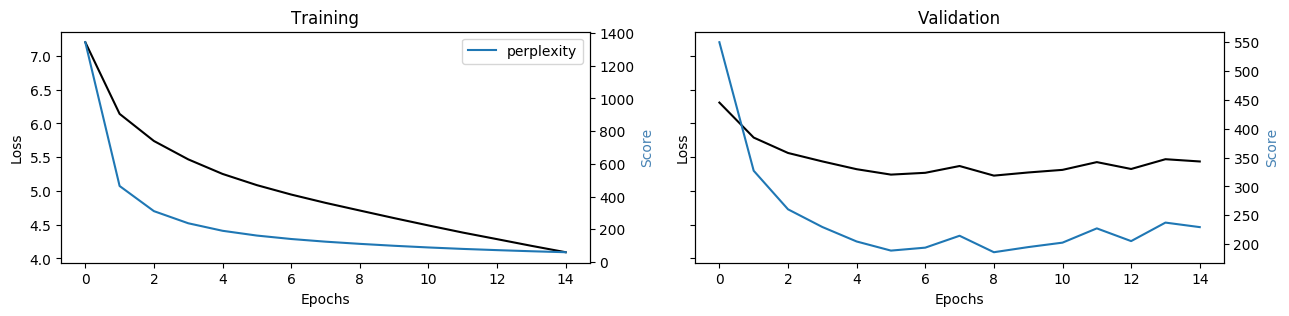

In [59]:
utils_plot_keras_training(saved_history)


In [60]:
from nlp_utils import create_stopwords, add_preprocessed_text

In [61]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [62]:
test = pd.read_csv('data/test.csv', index_col=0)

In [63]:
lst_stopwords = create_stopwords()
lst_stopwords = lst_stopwords + ["say","said","new","wa","ha", 'p', 'ci', 'v', 'n', 'itti', 'vs', 'pc', 'auc', 'itti']

columns = ['article', 'highlights']

params = {
    'punkt': True,
    'lower': True,
    'slang': True,
    'lst_stopwords': lst_stopwords,
    'lst_regex': [r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", r"\d+"],
    'lemm': True,
    # 'stemm' : True
}

for column in columns:
    params['column'] = column
    test = add_preprocessed_text(test, **params).reset_index(drop=True)

--- found NAs ---
                                           highlights highlights_clean
329                                                 U                 
352                                                 U                 
407  http://ctri.nic.in/Clinicaltrials/advsearch.php.                 
599                                                 U                 
680                2013-002932-25 and 2018-002064-15.                 


In [64]:

test_articles = test['article_clean'].tolist()
test_highlights= test['highlights_clean'].tolist()

In [65]:
test_pairs = list(zip(test_articles, test_highlights))

In [66]:
# batch_size = best_hps.get_config()['values']['batch_size']
batch_size = 32

In [67]:
NUM_BEAMS = 5

def decode_sequences(input_sentences, model):
    batch_size = tf.shape(input_sentences)[0]
    # Tokenize the encoder input.
    encoder_input_tokens = word_piece_atricle_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )
    encoder_input_tokens = tf.repeat(encoder_input_tokens, NUM_BEAMS, axis=0)
    # Define a function that outputs the next token's probability given the
    # input sequence.
    def next(prompt, cache, index):
        logits = model([encoder_input_tokens, prompt])[:, index - 1, :]
        # Ignore hidden states for now; only needed for contrastive search.
        hidden_states = None
        return logits, hidden_states, cache

    # Build a prompt of length 40 with a start token and padding tokens.
    length = 30
    start = tf.fill((batch_size, 1), word_piece_highlights_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, length - 1), word_piece_highlights_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat((start, pad), axis=-1)

    sampler = keras_nlp.samplers.BeamSampler(num_beams=5)
    
    output_tokens = sampler(
        next,
        prompt,
        end_token_id=word_piece_highlights_tokenizer.token_to_id("[END]"),
        index=1,
    )

    generated_sentences = word_piece_highlights_tokenizer.detokenize(output_tokens)
    
    return generated_sentences

In [68]:
test_article_texts = [article for article in test['article_clean'].tolist()]
test_highlight_texts = [article for article in test['highlights_clean'].tolist()]


for i in range(3):
    input_sentence = random.choice(test_article_texts)
    translated = decode_sequences(tf.constant([input_sentence]), model)
    # print(translated[0])
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(translated)

2023-06-14 08:56:51.221621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-14 08:56:51.486320: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x87a27220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-14 08:56:51.486378: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-06-14 08:56:51.865947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-14 08:56:52.130648: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


** Example 0 **
intervention largest number bs four time among participant intervention group among participant control group four month intervention mean difference score perceived susceptibility bse barrier selfefficacy health motivation significantly higher intervention group compared control group however significant difference observed two group regard perceived severity bse benefit intervention
finding suggest exercise intervention may effective intervention improving physical function
** Example 1 **
intention treat analysis risk death significantly lower titrated oxygen arm compared high flow oxygen arm patient high flow oxygen titrated oxygen subgroup patient confirmed chronic obstructive pulmonary disease high flow titrated overall mortality death high flow oxygen arm compared death titrated oxygen arm mortality subgroup confirmed chronic obstructive pulmonary disease death high flow arm compared death titrated oxygen arm titrated oxygen treatment reduced mortality compared h

In [69]:
from nlp_utils import display_string_matching

In [74]:
rouge_1_metric = keras_nlp.metrics.RougeN(order=1,use_stemmer=True)
# rouge_2 = keras_nlp.metrics.RougeN(order=2,use_stemmer=True)
rouge_l_metric = keras_nlp.metrics.RougeL(use_stemmer=True, name="rouge-l")


roug_l = keras_nlp.metrics.RougeL()

# test_pair = random.choice(test_pairs)

max_res = 0 

columns = ['Rouge-l', 'Rouge-1']
WordPiece = pd.DataFrame(columns=columns)

for _ in range(10):

    n = 10
    picked_elements = random.sample(test_pairs, n)

    for test_pair in picked_elements:
        input_sentence = test_pair[0]
        reference_sentence = test_pair[1]

        translated_sentence = decode_sequences(tf.constant([input_sentence]), model)
        translated_sentence = translated_sentence.numpy()[0].decode("utf-8")
        translated_sentence = (
            translated_sentence.replace("[PAD]", "")
            .replace("[START]", "")
            .replace("[END]", "")
            .strip()
        )

        rouge_l = rouge_l_metric(reference_sentence, translated_sentence)
        rouge_1 = rouge_1_metric(reference_sentence, translated_sentence)



    # Append the row to the DataFrame
    test =  rouge_1['f1_score'].numpy()
    print(f'test: {test}')
    print(f'max res: {max_res}')
    print('\n')
    
    rouge_1_res =  rouge_1['f1_score'].numpy()
    roug_l_res  =  rouge_l['f1_score'].numpy()
    new_row = [roug_l_res , rouge_1_res]
    WordPiece.loc[len(WordPiece)] = new_row
    if max_res < test:
        if max_res == 0:
            min_res = max_res
            rouge_1_min_res =  rouge_1['f1_score']
            roug_l_min_res =  rouge_l['f1_score']
        max_res = test

        # Create a row of numbers

# print("ROUGE-1 Score: ",rouge_1_res)
# print("ROUGE-2 Score: ", rouge_2.result()['f1_score'])
# print("ROUGE-L Score: ", roug_l_res)

test: 0.3571428656578064
max res: 0


test: 0.23120301961898804
max res: 0.3571428656578064


test: 0.17564071714878082
max res: 0.3571428656578064


test: 0.15554006397724152
max res: 0.3571428656578064


test: 0.14043204486370087
max res: 0.3571428656578064


test: 0.1784302145242691
max res: 0.3571428656578064


test: 0.15294018387794495
max res: 0.3571428656578064


test: 0.13382266461849213
max res: 0.3571428656578064


test: 0.13006459176540375
max res: 0.3571428656578064


test: 0.12395469099283218
max res: 0.3571428656578064


test: 0.11268608272075653
max res: 0.3571428656578064


test: 0.11758128553628922
max res: 0.3571428656578064


test: 0.10853657126426697
max res: 0.3571428656578064


test: 0.1160900816321373
max res: 0.3571428656578064


test: 0.11994494497776031
max res: 0.3571428656578064


test: 0.11244838684797287
max res: 0.3571428656578064


test: 0.10962884873151779
max res: 0.3571428656578064


test: 0.10938630253076553
max res: 0.3571428656578064


test: 0.1036

In [75]:
WordPiece = WordPiece.sort_values('Rouge-l', ascending=False).reset_index(drop=True)

In [76]:
WordPiece



,Rouge-l,Rouge-1
0,0.214286,0.357143
1,0.159774,0.231203
2,0.154621,0.178430
3,0.132532,0.152940
4,0.128022,0.175641
...,...,...
95,0.072844,0.087842
96,0.072703,0.087155
97,0.072455,0.086649
98,0.072369,0.087655


In [78]:
value = []

for experiment in metrics:
    for index, pair in enumerate(experiment):
        if index == 0:
            pair['f1_score']

In [80]:
train_dataset = make_dataset(train_pairs, preprocess_batch_sentencepiece, batch_size)

val_dataset = make_dataset(validate_pairs, preprocess_batch_sentencepiece, batch_size)


Tensor("args_0:0", shape=(None,), dtype=string)
tf.RaggedTensor(values=Tensor("sentence_piece_tokenizer_3/SentenceTokenizer/SentencepieceTokenizeOp:0", shape=(None,), dtype=int32), row_splits=Tensor("sentence_piece_tokenizer_3/SentenceTokenizer/SentencepieceTokenizeOp:1", shape=(None,), dtype=int64))
Tensor("args_0:0", shape=(None,), dtype=string)
tf.RaggedTensor(values=Tensor("sentence_piece_tokenizer_3/SentenceTokenizer/SentencepieceTokenizeOp:0", shape=(None,), dtype=int32), row_splits=Tensor("sentence_piece_tokenizer_3/SentenceTokenizer/SentencepieceTokenizeOp:1", shape=(None,), dtype=int64))


In [81]:
best_hps=tuner.get_best_hyperparameters()[0]

In [82]:
# model_2 = tuner.hypermodel.build(best_hps)

In [83]:
model_2 = keras.models.load_model('transformer_sentencepiece_model.h5')

In [84]:
# my_callback = keras.callbacks.EarlyStopping(monitor='val_perplexity', patience=4, mode='auto', min_delta=0, restore_best_weights=True)

# with tf.device('/GPU:0'):
#     model_2.fit(
#         x=train_dataset,
#         validation_data=val_dataset,
#         callbacks=my_callback,
#         epochs=150,
#         shuffle=True
#     )

# model.save("transformer_sentencepiece_model.h5")

In [85]:
# model_2.save("transformer_sentencepiece_model.h5")

In [86]:
# with open('history_sentencepiece.pkl', 'wb') as file:
#     pickle.dump(model_2.history, file)

In [87]:
with open('history_sentencepiece.pkl', 'rb') as file:
    saved_history = pickle.load(file)

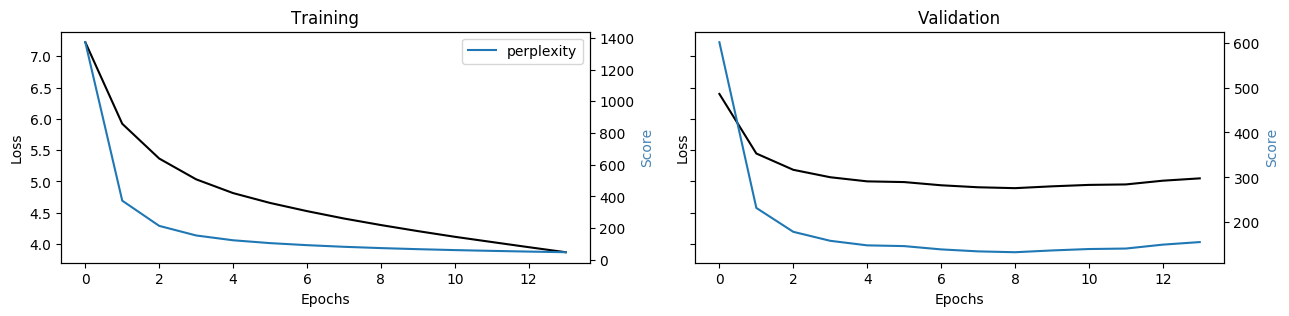

In [88]:
utils_plot_keras_training(saved_history)

In [89]:
# test_article_texts = [article for article in test['article_clean'].tolist()]
# test_highlight_texts = [article for article in test['highlights_clean'].tolist()]


for i in range(3):
    input_sentence = random.choice(test_article_texts)
    translated = decode_sequences(tf.constant([input_sentence]), model_2)
    # print(translated[0])
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(translated)

** Example 0 **
ninety woman metabolic syndrome obese bmi kgm percentage body fat revised bmi standard kgm cited current literature hierarchical logistic regression model adjusted age income education revealed higher percentage body fat associated greater prevalence metabolic syndrome alone higher fitness lowered odds metabolic syndrome lower odds significantly beyond effect body fat dichotomized fit unfit group woman categorized fat lower odds metabolic syndrome fit percentage body fat revised bmi respectively
weight loss overweight obese woman overweight obese woman overweight obese overweight obese woman   intervention
** Example 1 **
total patient group randomized primary outcome occurred patient gdht group patient usual care group absolute difference h intervention period patient gdht group received dobutamine compared usual care group metaanalysis nine randomized trial showed difference postoperative mortality risk ratio heterogeneity overall complication rate risk ratio heteroge

In [90]:
rouge_1_metric = keras_nlp.metrics.RougeN(order=1,use_stemmer=True)
# rouge_2 = keras_nlp.metrics.RougeN(order=2,use_stemmer=True)
rouge_l_metric = keras_nlp.metrics.RougeL(use_stemmer=True, name="rouge-l")


roug_l = keras_nlp.metrics.RougeL()

# test_pair = random.choice(test_pairs)

max_res = 0 

columns = ['Rouge-l', 'Rouge-1']
SentencePiece = pd.DataFrame(columns=columns)

for _ in range(10):

    n = 10
    picked_elements = random.sample(test_pairs, n)

    for test_pair in picked_elements:
        input_sentence = test_pair[0]
        reference_sentence = test_pair[1]

        translated_sentence = decode_sequences(tf.constant([input_sentence]), model_2)
        translated_sentence = translated_sentence.numpy()[0].decode("utf-8")
        translated_sentence = (
            translated_sentence.replace("[PAD]", "")
            .replace("[START]", "")
            .replace("[END]", "")
            .strip()
        )

        rouge_l = rouge_l_metric(reference_sentence, translated_sentence)
        rouge_1 = rouge_1_metric(reference_sentence, translated_sentence)



    # Append the row to the DataFrame
    test =  rouge_1['f1_score'].numpy()
    print(f'test: {test}')
    print(f'max res: {max_res}')
    print('\n')
    
    rouge_1_res =  rouge_1['f1_score'].numpy()
    roug_l_res  =  rouge_l['f1_score'].numpy()
    new_row = [roug_l_res , rouge_1_res]
    SentencePiece.loc[len(SentencePiece)] = new_row
    if max_res < test:
        if max_res == 0:
            min_res = max_res
            rouge_1_min_res =  rouge_1['f1_score']
            roug_l_min_res =  rouge_l['f1_score']
        max_res = test

# print("ROUGE-1 Score: ",rouge_1_res)
# print("ROUGE-2 Score: ", rouge_2.result()['f1_score'])
# print("ROUGE-L Score: ", roug_l_res)

test: 0.1915871649980545
max res: 0


test: 0.16295316815376282
max res: 0.1915871649980545


test: 0.13180433213710785
max res: 0.1915871649980545


test: 0.12508612871170044
max res: 0.1915871649980545


test: 0.1224111020565033
max res: 0.1915871649980545


test: 0.11159390956163406
max res: 0.1915871649980545


test: 0.10315211117267609
max res: 0.1915871649980545


test: 0.09691396355628967
max res: 0.1915871649980545


test: 0.09632217884063721
max res: 0.1915871649980545


test: 0.09821009635925293
max res: 0.1915871649980545




In [94]:
SentencePiece = SentencePiece.sort_values('Rouge-l', ascending=False).reset_index(drop=True)
SentencePiece

,Rouge-l,Rouge-1
0,0.140485,0.191587
1,0.127057,0.162953
2,0.106119,0.131804
3,0.103000,0.122411
4,0.102337,0.125086
5,0.095418,0.111594
6,0.088590,0.103152
7,0.084816,0.098210
8,0.084172,0.096914
9,0.084141,0.096322


In [95]:
increase_percentage = abs((WordPiece - SentencePiece) / SentencePiece) * 100


In [96]:
increase_percentage.mean()

Rouge-l    33.210846
Rouge-1    40.416676
dtype: float32